In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
import re

#### Project 1 Instructions
For your first project, you are asked to
Identify and load a network dataset that has some categorical information available for each node.
For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
Compare your centrality measures across your categorical groups.
For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.
You may work in a small group.  Your project should be delivered in an Jupyter Notebook, and posted in GitHub.  Your project is due end of day Sunday. You and your team should created a video presentation about your project. You should be ready to present your project in our Meet-up.

#### Data Summary/Introduction
The dataset chosen for review in the analysis is May 2023 CitiBike data, which is the most popular share bike network in metro NYC. It is released based on monthly cadence and tracks the beginning and ending destinations of each ride taken as well as some basic information on the ride itself. Ultimately, the Jersey subset of data was used as it was substantially smaller (NYC 3.8 million rides compared to 96k in NJ) that improved efficiencies for network visualizations and centrality calculations. Notably, a very small amount of these NJ tagged areas had start or end locations that were outside of NJ and were in NYC.

#### Load data from Github
* Original source: https://citibikenyc.com/system-data

#### Previewing Data
* Review fields and data types of dataset

In [2]:
nj_bike_path = 'https://raw.githubusercontent.com/jforster19/Data620/main/JC-202305-citibike-tripdata.csv'
bike_data = pd.read_csv(nj_bike_path)
bike_data['end_area'] = bike_data['end_station_id'].apply(lambda x: 'Hoboken' if str(x).startswith('HB')  else 'Jersey City')
bike_data['start_area'] = bike_data['start_station_id'].apply(lambda x: 'Hoboken' if str(x).startswith('HB')  else 'Jersey City')

In [9]:
bike_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,end_area,start_area
0,BC145343639B5E5B,classic_bike,2023-05-31 12:27:28,2023-05-31 12:38:36,Pershing Field,JC024,Newport PATH,JC066,40.742675,-74.051806,40.727224,-74.033759,member,Jersey City,Jersey City
1,A0CE41F47514FF5C,classic_bike,2023-05-01 18:12:37,2023-05-01 18:29:03,Pershing Field,JC024,Baldwin at Montgomery,JC020,40.742638,-74.051815,40.723659,-74.064194,casual,Jersey City,Jersey City
2,D588077E3D7E2AFD,electric_bike,2023-05-28 17:37:58,2023-05-28 18:39:39,Pershing Field,JC024,Pershing Field,JC024,40.742677,-74.051789,40.742677,-74.051789,casual,Jersey City,Jersey City
3,89AC48A5584B2DB4,classic_bike,2023-05-27 21:01:37,2023-05-27 21:13:16,Pershing Field,JC024,Manila & 1st,JC082,40.742677,-74.051789,40.721651,-74.042884,member,Jersey City,Jersey City
4,709E0B11AB4A0E6C,classic_bike,2023-05-22 12:38:54,2023-05-22 13:02:13,Pershing Field,JC024,Jersey & 3rd,JC074,40.742677,-74.051789,40.723332,-74.045953,member,Jersey City,Jersey City


In [4]:
bike_data.shape

(96002, 15)

In [5]:
bike_data.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'end_area', 'start_area'],
      dtype='object')

In [6]:
bike_data.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
end_area               object
start_area             object
dtype: object

In [7]:
pd.DataFrame(bike_data.groupby(['start_station_name','end_station_name'])['ride_id'].count().sort_values(ascending=False))

,,ride_id
start_station_name,end_station_name,
Hoboken Terminal - Hudson St & Hudson Pl,Hoboken Ave at Monmouth St,501
Liberty Light Rail,Liberty Light Rail,455
South Waterfront Walkway - Sinatra Dr & 1 St,South Waterfront Walkway - Sinatra Dr & 1 St,452
Grove St PATH,Marin Light Rail,444
McGinley Square,Bergen Ave & Sip Ave,389
...,...,...
2 St & Park Ave,City Hall,1
Pershing Field,Dixon Mills,1
Dey St,Grove St PATH,1


#### Draw preliminary graph for EDA

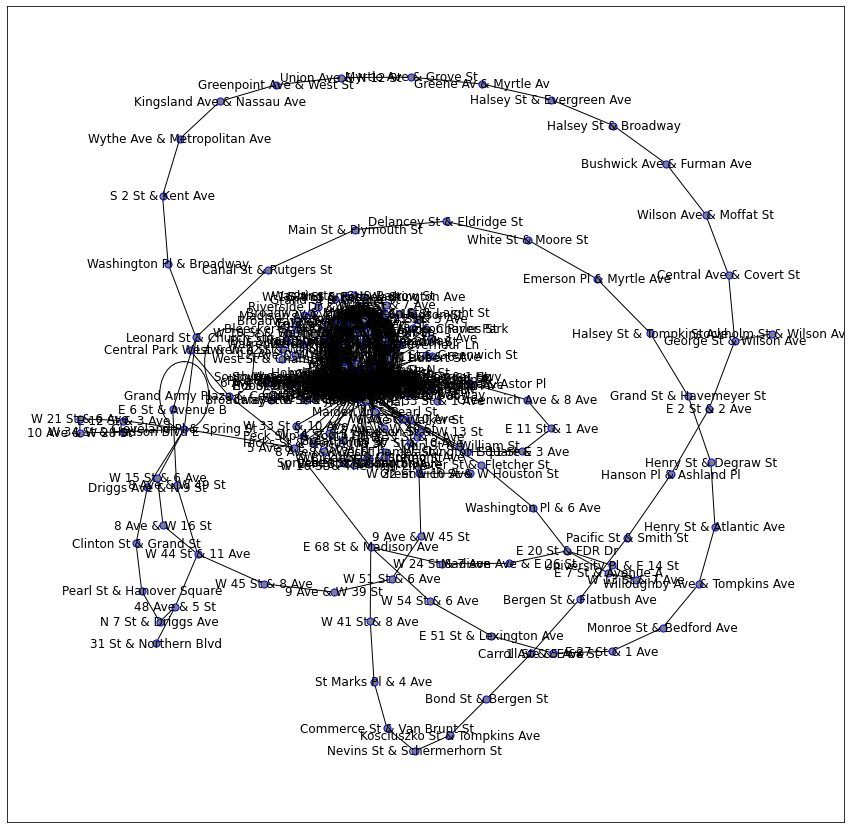

In [8]:
plt.rcParams['figure.figsize'] = [15, 15]
G = nx.from_pandas_edgelist(bike_data,'start_station_name','end_station_name',create_using=nx.Graph())
nx.draw_networkx(G,with_labels=True, edgecolors='blue', node_color='gray', node_size=50)
plt.show();

#### Reviewing number of stations (nodes)

In [15]:
len(bike_data['start_station_id'].unique())

167

#### Prepare dataset to create graph object
* Given there is positional data provided via longitude and latitude coordinates, we will add these attributes as the position of each node to review how it compares with the default behavior of the spacing algorithm.
* Cleaning the names of the stations to make them more legible in a visualization
* Excluding those bike trips without an end point as they represent a small population within the dataset and cause potential problems when building the visual

#### Replace nulls with values
* Selected random Jersey City coordinates for the point of reference for blank end stations
* Confirmed that there are no more nulls to prevent graphing warnings

In [16]:
bike_data['end_station_id'].fillna(value='0000',inplace=True)
bike_data['end_station_name'].fillna(value='None',inplace=True)
bike_data['end_lat'].fillna(value=40.727328,inplace=True)
bike_data['end_lng'].fillna(value=-74.038719,inplace=True)
bike_data.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
end_area              0
start_area            0
dtype: int64

#### Building out Network Graph

In [17]:
bike_graph = nx.Graph()

for row,col in bike_data.iterrows():
    bike_graph.add_node(col['start_station_id'], pos=(col['start_lat'], col['start_lng']),\
                            label=str(col['start_station_name']).replace(' ', ''), bike_type=col['rideable_type'],\
                            is_member=col['member_casual'], area=col['start_area'])
    bike_graph.add_node(col['end_station_id'], pos=(col['end_lat'], col['end_lng']),\
                        label=str(col['end_station_name']).replace(' ', ''), bike_type=col['rideable_type'],\
                        is_member=col['member_casual'], area=col['end_area'])
    bike_graph.add_edge(col['start_station_id'], col['end_station_id'])
    #weight=bike_data[(bike_data['start_station_id']==col['start_station_id']) & (bike_data['end_station_id']==col['end_station_id'])]['ride_id'].count()/bike_data.shape[0]

pos = nx.get_node_attributes(bike_graph,'pos')
labels = nx.get_node_attributes(bike_graph,'label')

The graph incorporated additional attributes to modify the lables as well as include some additional ride information that could enhance the edge information. Most of the categorical data provided tracked more closely to edges/rides which would not be ideal for calculating centrality statistics

In [19]:
# Stack Overflow code to inform colorizing nodes: https://stackoverflow.com/questions/27030473/how-to-set-colors-for-nodes-in-networkx
color_map = []
edge_color = []

for idx,node in enumerate(bike_graph.nodes()):
    if bike_graph.nodes[node]['bike_type']=='classic_bike':
        edge_color.append('solid')
    else: 
        edge_color.append('dashed') 
    if bike_graph.nodes[node]['area']=='Hoboken':
        color_map.append('orange')
    else: 
        color_map.append('blue')
        
color_map[:10]
edge_color[:10]


['dashed',
 'solid',
 'dashed',
 'solid',
 'solid',
 'solid',
 'solid',
 'solid',
 'dashed',
 'dashed']

ValueError: Unrecognized linestyle: ['dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed']

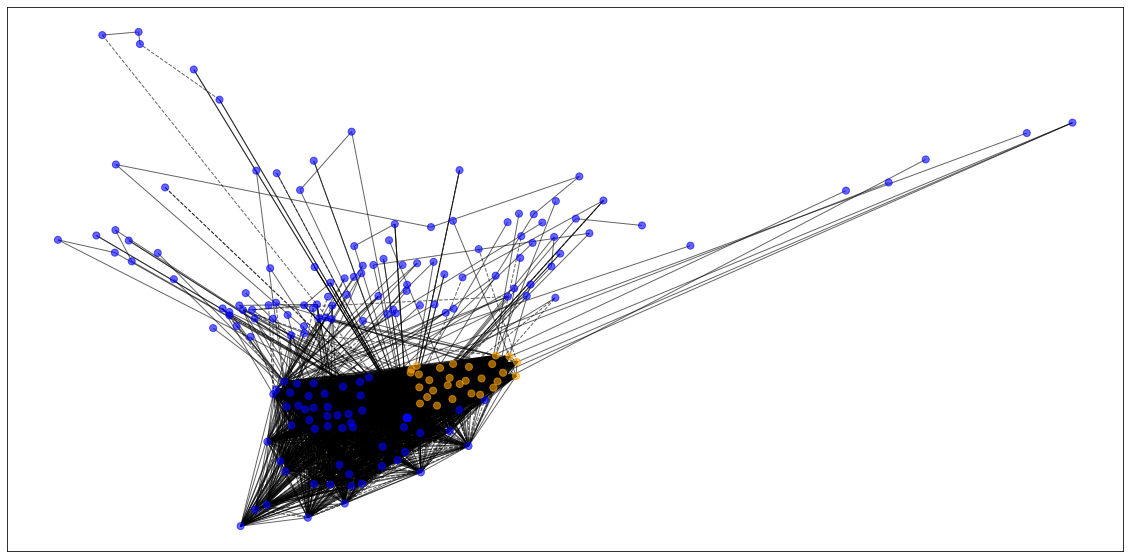

In [20]:
from matplotlib.lines import Line2D

plt.rcParams['figure.figsize'] = [20, 10]
nx.draw_networkx(bike_graph, pos, with_labels=True, labels=labels, node_color=color_map, alpha=0.6, style=edge_color,
                 node_size=50)

legend_elements = [Line2D([0], [0], marker='o', color='orange', lw=4, label='Hoboken'),
                   Line2D([0], [0], marker='o', color='blue', label='Jersey City'),\
                   Line2D([0], [0], marker='o', linestyle='solid', color='black', label='Classic Bike'),\
                   Line2D([0], [0], marker='o', linestyle='dashed', color='black', label='Electric Bike')]

plt.legend(legend_elements, ['Hoboken','Jersey City','Classic Bike','Electric Bike'])
plt.title('Metro NYC Citi Bike Network Graph')
plt.show();

The positions are driven off of the geom points provided for each station, but unfortunately are not separated enough to identify a very visible "map" of the areas closest to NYC in NJ. There are clearly some stations in Jersey City that are farther distance wise and likely are much less utilized compared to the majority of CitiBike locations

In [21]:
bike_data['end_station_id'].describe()

count     96002
unique      233
top       JC115
freq       4892
Name: end_station_id, dtype: object

In [87]:
bike_deg = nx.degree(bike_graph)

def trim_deg(graph, degrees):
    '''
    Using the function shown to prune the network in the textbook
    '''
    g2 = nx.Graph()
    d=nx.degree(g2)
    for idx, n in enumerate(g2.nodes()):
        if idx<=2:
            print(n, idx)
        if d[n]>=degrees:
            g2.add_node(n)
    return g2

#### Number of edges that would determine the cutoff

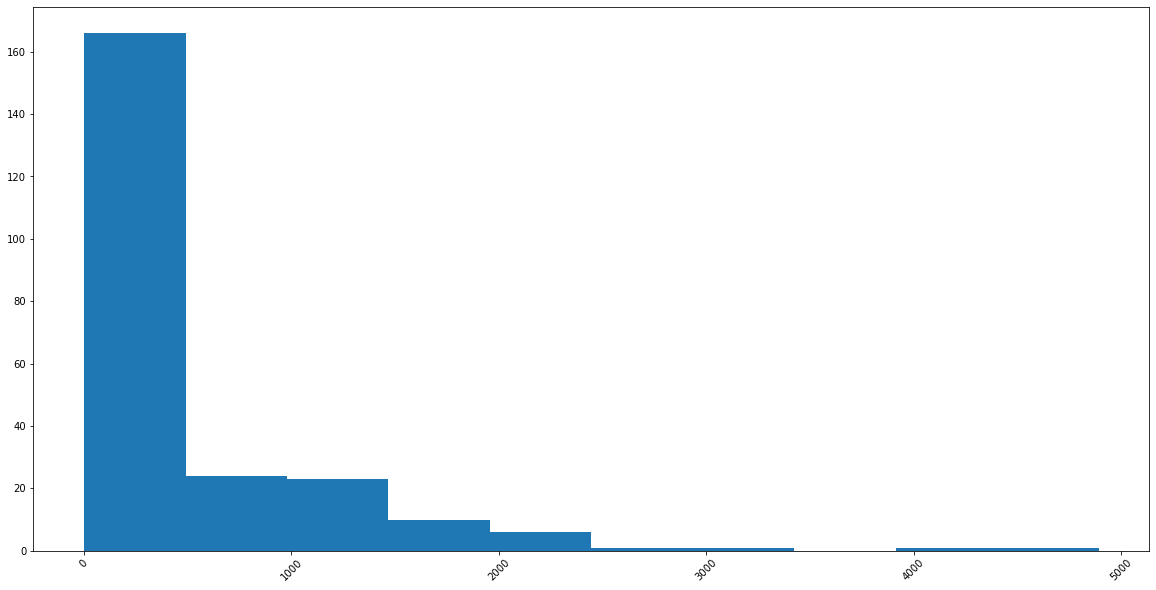

In [31]:
plt.hist(bike_data.groupby('end_station_name')['ride_id'].count().reset_index()[['ride_id']])
plt.xticks(rotation = 45)
plt.show();

In [89]:
bike_graph_trimmed = trim_deg(bike_graph, degrees=20)
bike_graph_trimmed
len(bike_graph_trimmed)

0

#### Calculate degree centrality and eigenvector centrality. 
Compare your centrality measures across your categorical groups

In [53]:
central_bikestats = nx.degree_centrality(bike_graph)
eigen_bikestats = nx.eigenvector_centrality(bike_graph)
close_bikestats = nx.closeness_centrality(bike_graph)
betw_stats = nx.betweenness_centrality(bike_graph)

#### Noting that there are more stations in `end_station_id` than in `start_station_id` so be sure to join on this.

In [59]:
print(np.setdiff1d(bike_data['end_station_id'].unique(), bike_data['start_station_id'].unique()))

['0000' '4596.09' '4645.09' '4889.06' '4953.04' '4993.15' '5033.01'
 '5096.12' '5105.01' '5114.06' '5137.10' '5156.05' '5159.04' '5207.01'
 '5216.06' '5288.09' '5297.02' '5329.03' '5368.03' '5430.08' '5470.10'
 '5470.12' '5500.02' '5500.07' '5509.02' '5561.06' '5569.06' '5636.11'
 '5679.08' '5696.03' '5712.12' '5763.03' '5779.08' '5847.01' '5847.06'
 '5847.08' '5905.12' '5914.03' '5914.08' '5980.07' '5997.10' '6098.10'
 '6115.06' '6157.04' '6197.08' '6233.05' '6322.01' '6450.05' '6464.09'
 '6492.04' '6541.03' '6551.02' '6560.14' '6578.01' '6593.15' '6611.02'
 '6659.09' '6762.02' '6765.01' '7141.07' '7340.06' '7745.07' '7886.02'
 '7981.16' '8226.07' '8358.03']


It appears that there are more end stations present in this month's feed from Citi Bike in NJ and it likely is due to riders taking trips to stops closer to their homes or other miscellaneous trips that may only be their final stopping point

Replacing id's with station names

In [60]:
named_bikestats = {bike_data.loc[bike_data['end_station_id']==k,'end_station_name'].unique()[0]:v for k,v in central_bikestats.items()}

In [61]:
sorted(named_bikestats.items(),key=lambda x:x[1], reverse=True)[:11]

[('Paulus Hook', 0.4224137931034483),
 ('Marin Light Rail', 0.3879310344827586),
 ('Hamilton Park', 0.36637931034482757),
 ('Grove St PATH', 0.36637931034482757),
 ('JC Medical Center', 0.36637931034482757),
 ('Pershing Field', 0.3620689655172414),
 ('Van Vorst Park', 0.3620689655172414),
 ('Newport PATH', 0.3577586206896552),
 ('Harborside', 0.3577586206896552),
 ('Newark Ave', 0.3577586206896552),
 ('Exchange Pl', 0.3577586206896552)]

Most of these stations are by the waterfront in Jersey City which has a nice bike path close to the water or is near a transit station. This makes a lot of sense as to why they are the most used stations for CitiBikes

#### Merge Centrality Statistics

In [62]:
cent_stats = pd.merge(pd.merge(pd.merge(pd.DataFrame(data=list(central_bikestats.items()),\
                                   columns=['node_id','degree_centrality']),\
                      pd.DataFrame(data=list(eigen_bikestats.items()),\
                                   columns=['node_id','eigen_centrality']),on='node_id'),\
                      pd.DataFrame(data=list(close_bikestats.items()),\
                                   columns=['node_id','closeness_centrality']),on='node_id'),\
                      pd.DataFrame(data=list(close_bikestats.items()),\
                                   columns=['node_id','betweenness_centrality']),on='node_id')

bike_data_group = pd.DataFrame(bike_data.groupby(['end_station_id','end_station_name','end_area'])['ride_id'].count().reset_index())
bike_data_group.rename(columns={'end_station_name':'station_name','end_area':'area','ride_id':'count'},inplace=True)
stats = pd.merge(cent_stats,bike_data_group,left_on='node_id',right_on='end_station_id')

stats.sort_values(by='eigen_centrality', ascending=False).head(10)

,node_id,degree_centrality,eigen_centrality,closeness_centrality,betweenness_centrality,end_station_id,station_name,area,count
7,JC009,0.366379,0.125389,0.204766,0.204766,JC009,Hamilton Park,Jersey City,2165
39,JC115,0.366379,0.125389,0.204766,0.204766,JC115,Grove St PATH,Jersey City,4892
0,JC024,0.362069,0.125364,0.204586,0.204586,JC024,Pershing Field,Jersey City,627
1,JC066,0.357759,0.124352,0.204405,0.204405,JC066,Newport PATH,Jersey City,2351
15,JC008,0.353448,0.123766,0.203866,0.203866,JC008,Newport Pkwy,Jersey City,2123
35,JC104,0.357759,0.123376,0.204046,0.204046,JC104,Harborside,Jersey City,1648
47,JC032,0.357759,0.123119,0.204405,0.204405,JC032,Newark Ave,Jersey City,1385
58,JC116,0.357759,0.122612,0.207143,0.207143,JC116,Exchange Pl,Jersey City,1505
82,JC006,0.349138,0.122554,0.203687,0.203687,JC006,Warren St,Jersey City,1401
8,HB101,0.349138,0.121751,0.203687,0.203687,HB101,Hoboken Terminal - Hudson St & Hudson Pl,Hoboken,2513


In [63]:
stats.sort_values(by='eigen_centrality',ascending=False).tail(10)

,node_id,degree_centrality,eigen_centrality,closeness_centrality,betweenness_centrality,end_station_id,station_name,area,count
228,4665.02,0.008621,5.244390e-10,0.076492,0.076492,4665.02,Willoughby Ave & Tompkins Ave,Jersey City,1
84,4319.07,0.008621,5.244390e-10,0.069357,0.069357,4319.07,Halsey St & Tompkins Ave,Jersey City,1
207,5267.08,0.008621,5.244390e-10,0.065853,0.065853,5267.08,Grand St & Havemeyer St,Jersey City,1
221,4531.05,0.008621,5.244390e-10,0.071738,0.071738,4531.05,Henry St & Atlantic Ave,Jersey City,1
208,4380.08,0.008621,5.244390e-10,0.068336,0.068336,4380.08,Henry St & Degraw St,Jersey City,1
101,4784.02,0.008621,5.244390e-10,0.063095,0.063095,4784.02,Greene Av & Myrtle Av,Jersey City,1
102,4816.05,0.008621,5.244390e-10,0.066763,0.066763,4816.05,Myrtle Ave & Grove St,Jersey City,1
141,5411.07,0.008621,5.244390e-10,0.070883,0.070883,5411.07,Union Ave & N 12 St,Jersey City,1
139,4404.10,0.008621,5.244390e-10,0.078352,0.078352,4404.10,Bond St & Bergen St,Jersey City,1
165,4824.03,0.004310,3.899122e-10,0.052775,0.052775,4824.03,Stockholm St & Wilson Ave,Jersey City,1


Reviewing the top/bottom 10 based on eigenvector centrality we see several transit stations (Path or Light Rail) which actually make a ton of sense for why they are often the highest eigenvector centrality stations as they are convenient and great options for commuters for part of their journey to/from NYC. The bottom 10 do not seem familiar, and are likely more spaced out stations that get far less traffic due to their distance from other key areas in Jersey City

#### Confirming there were no breaks in the join

In [64]:
stats.isnull().sum()

node_id                   0
degree_centrality         0
eigen_centrality          0
closeness_centrality      0
betweenness_centrality    0
end_station_id            0
station_name              0
area                      0
count                     0
dtype: int64

#### Grouping on categorical data to compare summary statistics

We see higher centrality and lower variation in Hoboken than in Jersey City, likely because Hoboken is smaller.

In [65]:
stats.groupby('area').agg(['mean','std','max','min'])

degree_centrality                               eigen_centrality  \
                         mean       std       max       min             mean   
area                                                                           
Hoboken              0.308264  0.024126  0.349138  0.258621         0.108532   
Jersey City          0.090433  0.139459  0.422414  0.004310         0.029667   

                                              closeness_centrality            \
                  std       max           min                 mean       std   
area                                                                           
Hoboken      0.007891  0.121751  9.084197e-02             0.199827  0.004204   
Jersey City  0.048480  0.125389  3.899122e-10             0.152931  0.046706   

                                betweenness_centrality                      \
                  max       min                   mean       std       max   
area                                                                         
Hoboken      0.203687  0.186946               0.199827  0.004204  0.203687   
Jersey City  0.211293  0.052088               0.152931  0.046706  0.211293   

                             count                         
                  min         mean         std   max  min  
area                                                       
Hoboken      0.186946  1489.896552  782.256687  4063  658  
Jersey City  0.052088   258.799020  589.093136  4892    1

In [66]:
stats.groupby('area')['count'].sum()

area
Hoboken        43207
Jersey City    52795
Name: count, dtype: int64

After reviewing the summarized centrality statistics, it is somewhat interesting to review the data based on the neighborhood area (i.e. Hoboken/Jersey City). The means in general of Hoboken are quite a bit larger for almost all of the statistics with less variability across the various stations in that area. Part of the reason for this is due to the small size as Hoboken (1 sq. mile vs 21 sq. miles) is only one square mile from start to finish and there aren't many stations that are out of the way. Most of Hoboken is flat which makes it fairly convenient to ride to/from almost any destination with CitiBike. Jersey City on the other hand is so much larger of a city (21 sq. miles vs 1 sq. mile) and due to that size has a wide variety of station types. Some that are clearly hubs while others are less used residential areas that get far less traffic and riders, which explains why the stations in this Jersey City dominate both the top and bottom in terms of centrality - people visit them more on average than stations in Hoboken.